In [154]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning modules

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [155]:
# Filter methods

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from functools import partial

### Preprocessing the Data for Machine Learning Models

1. **Data Encoding:**
   - Encode categorical variables into numerical representations using techniques like one-hot encoding or label encoding.

2. **Normalization and Scaling:**
   - Normalize or scale numerical features to ensure uniformity and improve model performance.
   - Techniques include Min-Max scaling or Standardization.

3. **Feature Selection Methods**
    - Techniques include: filter, wrapper, and embedded methods.

4. **Data Splitting:**
   - Split the dataset into training and testing sets for machine learning models.

In [156]:
# Read ML file
file_path = './data/vax_trials_ml_df.csv'
df_ml = pd.read_csv(file_path)

# Display the DataFrame
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,dropout_rate,AE_total_serious,AE_total_other,injection site reactions,pyrexia,headache,irritability,pain
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,3.111111,1.0,1082.0,470,58,190,0,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,11.764706,3.0,100.0,8,3,1,0,0
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,1.818182,349.0,1716.0,0,70,204,0,460
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,3.611971,119.0,4625.0,2381,188,287,0,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,8.532934,140.0,3398.0,604,190,436,0,0


- Data encoding: 

    - clinical trial phase
    - gender

In [157]:
# Define mapping for phase categories to numerical values
phase_mapping = {
    'Early Phase 1': 1,
    'Phase 1': 2,
    'Phase 1/Phase 2': 3,
    'Phase 2': 4,
    'Phase 2/Phase 3': 5,
    'Phase 3': 6,
    'Phase 4': 7,
    'Not Applicable': 0
}

# Map the 'phase' column to numerical values
df_ml['phase_encoded'] = df_ml['phase'].map(phase_mapping)

# Display df
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,dropout_rate,AE_total_serious,AE_total_other,injection site reactions,pyrexia,headache,irritability,pain,phase_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,3.111111,1.0,1082.0,470,58,190,0,0,6
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,11.764706,3.0,100.0,8,3,1,0,0,2
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,1.818182,349.0,1716.0,0,70,204,0,460,4
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,3.611971,119.0,4625.0,2381,188,287,0,0,6
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,8.532934,140.0,3398.0,604,190,436,0,0,4


In [158]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'gender' column
df_ml['gender_encoded'] = le.fit_transform(df_ml['gender'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,phase,enrollment,condition_name,actual_duration,gender,dropout_rate,AE_total_serious,AE_total_other,injection site reactions,pyrexia,headache,irritability,pain,phase_encoded,gender_encoded
0,NCT00444951,Phase 3,450.0,infectious diseases,12.0,All,3.111111,1.0,1082.0,470,58,190,0,0,6,0
1,NCT00623831,Phase 1,17.0,cancer,60.0,All,11.764706,3.0,100.0,8,3,1,0,0,2,0
2,NCT00434577,Phase 2,715.0,infectious diseases,7.0,All,1.818182,349.0,1716.0,0,70,204,0,460,4,0
3,NCT00616421,Phase 3,2907.0,infectious diseases,13.0,All,3.611971,119.0,4625.0,2381,188,287,0,0,6,0
4,NCT04515147,Phase 2,668.0,infectious diseases,17.0,All,8.532934,140.0,3398.0,604,190,436,0,0,4,0


In [159]:
# Drop 'phase' and 'gender' columns
df_ml = df_ml.drop(['phase', 'gender'], axis=1)

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,dropout_rate,AE_total_serious,AE_total_other,injection site reactions,pyrexia,headache,irritability,pain,phase_encoded,gender_encoded
0,NCT00444951,450.0,infectious diseases,12.0,3.111111,1.0,1082.0,470,58,190,0,0,6,0
1,NCT00623831,17.0,cancer,60.0,11.764706,3.0,100.0,8,3,1,0,0,2,0
2,NCT00434577,715.0,infectious diseases,7.0,1.818182,349.0,1716.0,0,70,204,0,460,4,0
3,NCT00616421,2907.0,infectious diseases,13.0,3.611971,119.0,4625.0,2381,188,287,0,0,6,0
4,NCT04515147,668.0,infectious diseases,17.0,8.532934,140.0,3398.0,604,190,436,0,0,4,0


#### Feature selection methods

Filter methods

- Variance threshold: to remove any features that have little to no variation in their values.
- Pearson’s correlation: measuring the linear relationship between two numeric, continuous variables. Correlation between features, and correlation between features and target.
- F-statistic: correlation between features and target.
- Mutual information: measures the dependence between two variables and can be used to estimate how much a feature contributes to the prediction of the target variable.

In [160]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'phase_encoded', 'gender_encoded', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

In [161]:
# Variance threshold
selector = VarianceThreshold(threshold=0)  # 0 is default
print(selector.fit_transform(features))

[[4.500e+02 1.200e+01 1.000e+00 ... 1.900e+02 0.000e+00 0.000e+00]
 [1.700e+01 6.000e+01 3.000e+00 ... 1.000e+00 0.000e+00 0.000e+00]
 [7.150e+02 7.000e+00 3.490e+02 ... 2.040e+02 0.000e+00 4.600e+02]
 ...
 [3.000e+02 7.000e+00 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.447e+03 1.200e+01 9.300e+01 ... 6.350e+02 0.000e+00 1.341e+03]
 [4.800e+01 3.000e+00 6.000e+00 ... 8.000e+00 0.000e+00 1.000e+00]]


In [162]:
# Use indices to get the corresponding column names of selected features
num_cols = list(features.columns[selector.get_support(indices=True)])
print(num_cols)

['enrollment', 'actual_duration', 'AE_total_serious', 'AE_total_other', 'injection site reactions', 'pyrexia', 'headache', 'irritability', 'pain']


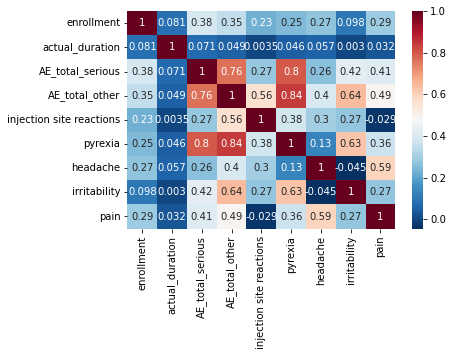

In [163]:
# Pearson’s correlation: 
# Correlation between features: drop highly correlated features to avoid duplicate information.

corr_matrix = features.corr(method='pearson') 

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [164]:
# Correlation between features and target

X_y = features.copy()
X_y['dropout_rate'] = target

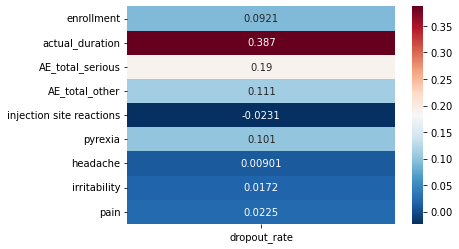

In [165]:
corr_matrix = X_y.corr()

# Isolate the column corresponding to 'dropout'
corr_target = corr_matrix[['dropout_rate']].drop(labels=['dropout_rate'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [166]:
# F-statistic: correlation between features and target
# The F-statistic will be larger (and p-value will be smaller) for predictors that are more highly correlated with the target variable
# First array: F-statistic
# Second array: p-value

print(f_regression(features, target))

(array([8.77101214e+00, 1.80494382e+02, 3.83379042e+01, 1.27428370e+01,
       5.47367328e-01, 1.06631201e+01, 8.33518924e-02, 3.01982995e-01,
       5.20573295e-01]), array([3.13105485e-03, 5.04123953e-38, 8.59275090e-10, 3.73924089e-04,
       4.59564650e-01, 1.12908792e-03, 7.72863711e-01, 5.82761511e-01,
       4.70761616e-01]))


In [167]:
# # features
# features = df_ml.drop(['nct_id', 'condition_name', 'dropout_rate'], axis=1)
# features.head()

In [168]:
# Mutual information

# features
features = df_ml.drop(['nct_id', 'condition_name', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

print(mutual_info_regression(features, target, discrete_features=[9,10], random_state=68))

[0.20060721 0.188058   0.09445215 0.07672191 0.02906857 0.06149891
 0.03271334 0.04041876 0.01562538 0.03192588 0.02956912]


In [187]:
score_func = partial(mutual_info_regression, discrete_features=[9,10], random_state=68)

# Select top 3 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=5)

print(selection.fit_transform(features, target))

[[4.500e+02 1.200e+01 1.000e+00 1.082e+03 5.800e+01]
 [1.700e+01 6.000e+01 3.000e+00 1.000e+02 3.000e+00]
 [7.150e+02 7.000e+00 3.490e+02 1.716e+03 7.000e+01]
 ...
 [3.000e+02 7.000e+00 3.000e+00 4.200e+01 0.000e+00]
 [1.447e+03 1.200e+01 9.300e+01 5.699e+03 1.390e+02]
 [4.800e+01 3.000e+00 6.000e+00 2.480e+02 1.000e+00]]


In [188]:
X = features[features.columns[selection.get_support(indices=True)]]
print(X)

      enrollment  actual_duration  AE_total_serious  AE_total_other  pyrexia
0          450.0             12.0               1.0          1082.0       58
1           17.0             60.0               3.0           100.0        3
2          715.0              7.0             349.0          1716.0       70
3         2907.0             13.0             119.0          4625.0      188
4          668.0             17.0             140.0          3398.0      190
...          ...              ...               ...             ...      ...
1023       406.0             19.0               0.0           169.0        0
1024        50.0             56.0              38.0           123.0       30
1025       300.0              7.0               3.0            42.0        0
1026      1447.0             12.0              93.0          5699.0      139
1027        48.0              3.0               6.0           248.0        1

[1028 rows x 5 columns]


One-Hot Encoding:

- dummy variables are created to handle categorical variables. They transform each category within a variable into its own binary identifier.
- disadvantage: it can lead to a high-dimensional feature space if there are many unique diseases, so it may not be efficient for large datasets.

In [189]:
# Create dummy variables for 'condition_name' 
df_ml = pd.get_dummies(df_ml, columns=['condition_name'], prefix=['condition'])
df_ml.head()

KeyError: "None of [Index(['condition_name'], dtype='object')] are in the [columns]"

#### Select Variables

The data for the model will consist of a subset of variables. The **x** dataframe will contain features that could serve as good predictors for patient dropout in clinical trials. The **y** dataframe will include the target column, denoted by the 'dropout_rate', indicating the percentage of dropouts per clinical trial.

**Table 1.**

target variable: 

- dropout_rate

features:

- enrollment: total number of participants.
- condition_name: the grouped conditions were one-hot encoded.
- actual_duration: total duration.
- phase_encoded: phase categories mapped to numerical values.
- AE_total_serious: frequency of serious adverse events.

In [172]:
# Select variables
x = df_ml.drop(['nct_id', 'dropout_rate', 'AE_total_other', 'gender_encoded' ], axis=1)
y = df_ml['dropout_rate']

#### Splitting the Data

Next, the data needs to be divided into training and validation sets. In this split, 20% of the data is reserved for final validation, while 80% is allocated for training the model.

In [173]:
# Splitting the data

#Validation chunk size
val_size = 0.20

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 0)

#### Prediction

- **Model Building:** for this project, four algorithms will be used to make predictions:

  1. Linear Regression
  2. K Nearest Neighbor
  3. Decision Trees
  4. Random Forests

- **Evaluation Metrics:**
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)
  - R-squared (R2)

##### Multiple Linear Regression

In [174]:
# Initialize and train a linear regression model
lm = LinearRegression()
lm.fit(x_train, y_train)

# Make predictions on the test set
y_pred = lm.predict(x_test)

In [175]:
# Print coeficients and intercept
print("Coefficients of each feature:", lm.coef_)
print("Intercept:", lm.intercept_)

Coefficients of each feature: [ 2.97796066e-04  1.48480852e-01  3.45302555e-04 -5.29997302e-04
 -1.55719157e-04  5.28091034e-04  5.03894761e-04 -9.14096570e-04
 -1.55991449e-01 -7.09028909e+00  9.47773187e+00  1.25482775e+01
  3.41099650e+00  1.77635684e-15 -2.86353535e+00 -1.26503317e+01
 -1.14331208e+00  9.41805314e+00 -6.76626244e+00 -2.62303190e+00
 -1.71829647e+00]
Intercept: 6.395648361393958


In [176]:
#Print train and test score
print("Train score:")
print(lm.score(x_train, y_train))

print("Test score:")
print(lm.score(x_test, y_test))

Train score:
0.21558351432199307
Test score:
0.17950307659022224


In [177]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 198.69510200207074
Root Mean Squared Error: 14.095925014062423
Mean Absolute Error: 7.927530988119465
R-squared: 0.17950307659022224


##### K Nearest Neighbor

In [178]:
# Initialize the KNN regressor 
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the KNN regressor on the training data
knn_regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = knn_regressor.predict(x_test)

In [179]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 225.45085772707654
Root Mean Squared Error: 15.015021069817935
Mean Absolute Error: 8.029885538534893
R-squared: 0.06901713589681735


#### Hyperparameter tuning

In [180]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],   # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski metric
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Mean Squared Error: 233.37429572689376
Mean Absolute Error: 7.825462086110075
R-squared: 0.036297876910703075


##### Decision Trees

In [182]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

-0.015313881586338729


#### Hyperparameter tuning

In [183]:
# Define parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'max_depth': 3, 'min_samples_split': 10}
Mean Squared Error: 226.20297773153203
Root Mean Squared Error: 15.040045802175339
Mean Absolute Error: 7.9760949419934635
R-squared: 0.06591131122639216


In [184]:
# # Plot tree
# plt.figure(figsize=(10,10))
# tree.plot_tree(dt, feature_names = x_train.columns,  
#               filled=True)

##### Random Forests

In [185]:
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
r_squared_train = rfr.score(x_train, y_train)
r_squared_test = rfr.score(x_test, y_test)


# Print `R^2` scores on training and test data
print(f'Train set R^2: {r_squared_train}')
print(f'Test set R^2: {r_squared_test}')

# Print Mean Absolute Error on training and test data
avg_dropout = y.mean()
print(f'Avg dropout rates Train/Test: {avg_dropout}')

y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train set MAE: {mae_train}')

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test set MAE: {mae_test}')

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (test):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (test):", rmse)

Train set R^2: 0.8914820304260094
Test set R^2: -0.03432553181078535
Avg dropout rates Train/Test: 9.320806910995117
Train set MAE: 3.023080107911949
Test set MAE: 8.655963457925342
Mean Squared Error (test): 226.20297773153203
Root Mean Squared Error (test): 15.040045802175339


Default Score: 0.009449951275362967
Minimum Test MSE: 204.86650831600053
Best Depth: 2


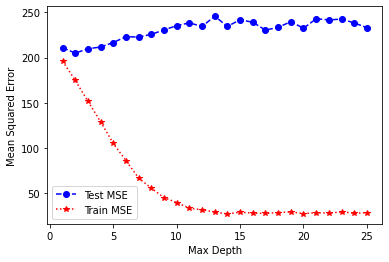

Top 5 Random Forest Features:
                            Feature  Importance
1                   actual_duration    0.644305
0                        enrollment    0.219728
11                 condition_cancer    0.103959
2                  AE_total_serious    0.022063
17  condition_inflammatory diseases    0.007349


In [186]:
# Instantiate random forest regressor, fit and score with default parameters
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
print("Default Score:", rfr.score(x_test, y_test))

# Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
mse_train = []
mse_test = []

depths = range(1, 26)
for i in depths:
    rfr = RandomForestRegressor(max_depth=i)
    rfr.fit(x_train, y_train)
    y_pred_test = rfr.predict(x_test)
    y_pred_train = rfr.predict(x_train)
    mse_test.append(mean_squared_error(y_test, y_pred_test))
    mse_train.append(mean_squared_error(y_train, y_pred_train))

# Find the best accuracy and at what depth that occurs
print("Minimum Test MSE:", np.min(mse_test))
best_depth = depths[np.argmin(mse_test)]
print("Best Depth:", best_depth)

# Plot the MSE scores for the test and train set over the range of depth values
plt.plot(depths, mse_test, 'bo--', depths, mse_train, 'r*:')
plt.legend(['Test MSE', 'Train MSE'])
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

# Save the best random forest model and save the feature importances in a dataframe
best_rfr = RandomForestRegressor(max_depth=best_depth)
best_rfr.fit(x_train, y_train)
feature_imp_df = pd.DataFrame(zip(x_train.columns, best_rfr.feature_importances_), columns=['Feature', 'Importance'])
print('Top 5 Random Forest Features:')
print(feature_imp_df.sort_values('Importance', ascending=False).iloc[:5])